# Do stricter gun laws reduce firearm gun deaths?

In [82]:
import requests
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

### Datasources

We can use the below NCHS API endpoint to see cause of death rates per state per quarter in the US. This will be a good starting point as we look to visualize per state



In [83]:
# Grabbing data from API endpoint
response = requests.get("https://data.cdc.gov/resource/489q-934x.json").json()

In [84]:
# Write response to pandas dataframe
df = pd.json_normalize(response)
df.head()

,year_and_quarter,time_period,cause_of_death,rate_type,unit,rate_overall,rate_sex_female,rate_sex_male,rate_alaska,rate_alabama,...,rate_age_1_4,rate_age_5_14,rate_age_15_24,rate_age_25_34,rate_age_35_44,rate_age_45_54,rate_age_55_64,rate_65_74,rate_age_75_84,rate_age_85_plus
0,2022 Q1,12 months ending with quarter,All causes,Age-adjusted,"Deaths per 100,000",873.2,729.4,1038,944.5,1109.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022 Q1,12 months ending with quarter,Alzheimer disease,Age-adjusted,"Deaths per 100,000",30.6,35,23.8,28.5,45.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022 Q1,12 months ending with quarter,COVID-19,Age-adjusted,"Deaths per 100,000",95,75.2,119.1,121.3,133.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022 Q1,12 months ending with quarter,Cancer,Age-adjusted,"Deaths per 100,000",145.9,127.4,170.9,156,159.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022 Q1,12 months ending with quarter,Chronic liver disease and cirrhosis,Age-adjusted,"Deaths per 100,000",14.4,10.3,18.9,25.5,16.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Filter for Firearm-Related Deaths:

In [85]:
# Filter the DataFrame for firearm-related deaths
df_firearm = df[df['cause_of_death'].str.contains('Firearm', case=False, na=False)]


2. Categorize Gun Laws:

In [86]:
# Example gun law strictness categories (simplified version)
gun_laws = {
    'California': 5,
    'Texas': 1,
    'New York': 4,
    'Alabama': 2,
    'Florida': 2,
    'Illinois': 4,
    'Arizona': 2,
    'Alaska': 1,
    'Arkansas': 1,
    # Add other states as needed...
}

# Convert the gun law strictness dictionary into a DataFrame
df_gun_laws = pd.DataFrame(list(gun_laws.items()), columns=['state', 'gun_law_strictness'])
df_gun_laws.head()


,state,gun_law_strictness
0,California,5
1,Texas,1
2,New York,4
3,Alabama,2
4,Florida,2


3. Load Firearm Mortality Data from

In [87]:
# Load the firearm mortality data from CSV
df_firearm_mortality = pd.read_csv('/content/data-table.csv')

# Check the structure of the data
df_firearm_mortality.head()

# Rename columns if necessary to ensure matching with other datasets
df_firearm_mortality.columns = ['year', 'state', 'rate', 'deaths', 'url']
df_firearm_mortality.head()


,year,state,rate,deaths,url
0,2022,AL,25.5,"1,278",/nchs/pressroom/states/alabama/al.htm
1,2022,AK,22.4,164,/nchs/pressroom/states/alaska/ak.htm
2,2022,AZ,20.1,"1,535",/nchs/pressroom/states/arizona/az.htm
3,2022,AR,21.9,666,/nchs/pressroom/states/arkansas/ar.htm
4,2022,CA,8.6,"3,484",/nchs/pressroom/states/california/ca.htm


Step 4: Standardize State Names or Abbreviations

In [88]:
# Dictionary to map state abbreviations to full names
state_abbreviation_to_name = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'TX': 'Texas',
    # Add other states as needed...
}

# Convert state abbreviations in the firearm mortality data to full state names
df_firearm_mortality['state'] = df_firearm_mortality['state'].map(state_abbreviation_to_name)

# Check to ensure mapping worked
df_firearm_mortality.head()


,year,state,rate,deaths,url
0,2022,Alabama,25.5,"1,278",/nchs/pressroom/states/alabama/al.htm
1,2022,Alaska,22.4,164,/nchs/pressroom/states/alaska/ak.htm
2,2022,Arizona,20.1,"1,535",/nchs/pressroom/states/arizona/az.htm
3,2022,Arkansas,21.9,666,/nchs/pressroom/states/arkansas/ar.htm
4,2022,California,8.6,"3,484",/nchs/pressroom/states/california/ca.htm


Step 5: Merge the Firearm Mortality Data with Gun Law Strictness Data

In [89]:
# Merge firearm mortality data with gun law strictness data
merged_df = df_firearm_mortality.merge(df_gun_laws, on='state', how='inner')

# Check the merged DataFrame
merged_df.head()


,year,state,rate,deaths,url,gun_law_strictness
0,2022,Alabama,25.5,"1,278",/nchs/pressroom/states/alabama/al.htm,2
1,2022,Alaska,22.4,164,/nchs/pressroom/states/alaska/ak.htm,1
2,2022,Arizona,20.1,"1,535",/nchs/pressroom/states/arizona/az.htm,2
3,2022,Arkansas,21.9,666,/nchs/pressroom/states/arkansas/ar.htm,1
4,2022,California,8.6,"3,484",/nchs/pressroom/states/california/ca.htm,5


Step 6: Visualize the Relationship Between Gun Law Strictness and Firearm Mortality

We’ll now visualize the relationship between gun law strictness and firearm mortality to see if stricter laws correlate with lower death rates.

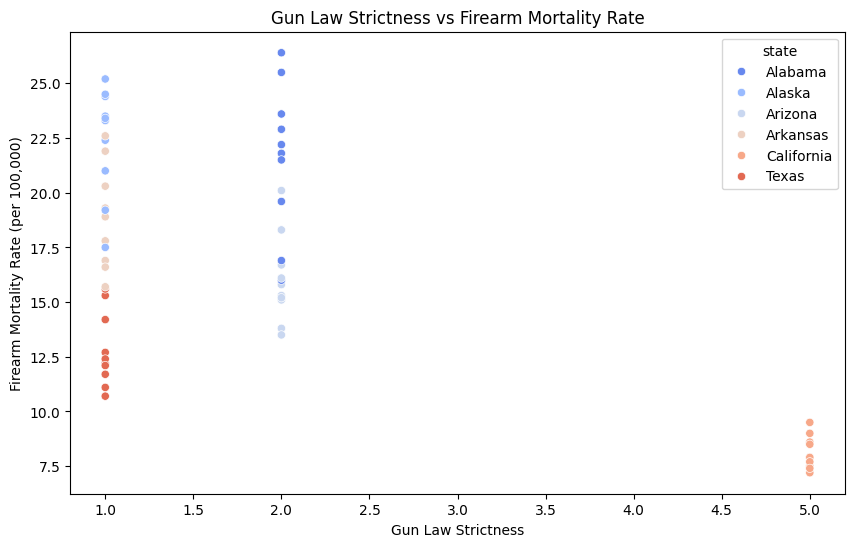

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot gun law strictness vs. firearm mortality rate
plt.figure(figsize=(10,6))
sns.scatterplot(x='gun_law_strictness', y='rate', data=merged_df, hue='state', palette='coolwarm')
plt.title('Gun Law Strictness vs Firearm Mortality Rate')
plt.xlabel('Gun Law Strictness')
plt.ylabel('Firearm Mortality Rate (per 100,000)')
plt.show()


In [91]:
# Calculate the correlation between gun law strictness and firearm mortality rate
correlation = merged_df['gun_law_strictness'].corr(merged_df['rate'])
print(f"Correlation between gun law strictness and firearm mortality rate: {correlation}")


Correlation between gun law strictness and firearm mortality rate: -0.6459737881159037


Interpretation of Results
Correlation Value: The correlation value of -0.6459737881159037 suggests a moderate to strong negative correlation between gun law strictness and firearm mortality rates. This indicates that as gun laws become stricter, firearm mortality rates tend to decrease.


In [92]:
# Create a pivot table for average firearm mortality rate by gun law strictness
pivot_table = merged_df.pivot_table(values='rate', index='state', columns='gun_law_strictness', aggfunc='mean')

# Fill any missing values with 0 for better visualization
pivot_table = pivot_table.fillna(0)


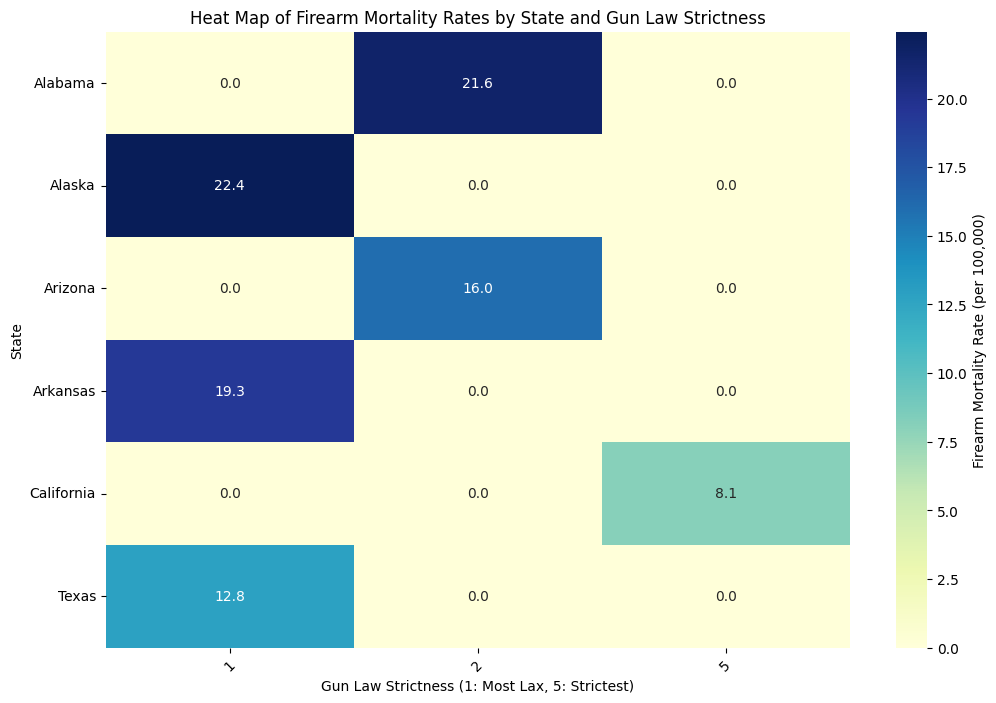

In [93]:
# Create a heat map using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'Firearm Mortality Rate (per 100,000)'})
plt.title('Heat Map of Firearm Mortality Rates by State and Gun Law Strictness')
plt.xlabel('Gun Law Strictness (1: Most Lax, 5: Strictest)')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [94]:
# Latitude and longitude for each state
state_coordinates = {
    'Alabama': [32.806671, -86.791397],
    'Alaska': [61.370716, -152.404419],
    'Arizona': [33.729759, -111.431221],
    'Arkansas': [34.969704, -92.373123],
    'California': [36.116203, -119.681564],
    'Texas': [31.968599, -99.901810],
    'New York': [42.165726, -74.948051],
    'Florida': [27.766279, -81.686783],
    'Illinois': [40.633125, -89.398528],
    # Add other states...
}

# Convert to DataFrame for merging
df_coordinates = pd.DataFrame.from_dict(state_coordinates, orient='index', columns=['latitude', 'longitude'])
df_coordinates.index.name = 'state'
df_coordinates.reset_index(inplace=True)


In [95]:
# Merge coordinates with the merged DataFrame
merged_df = merged_df.merge(df_coordinates, on='state', how='inner')

# Check the merged DataFrame to ensure it contains latitude and longitude
merged_df.head()


,year,state,rate,deaths,url,gun_law_strictness,latitude,longitude
0,2022,Alabama,25.5,"1,278",/nchs/pressroom/states/alabama/al.htm,2,32.806671,-86.791397
1,2022,Alaska,22.4,164,/nchs/pressroom/states/alaska/ak.htm,1,61.370716,-152.404419
2,2022,Arizona,20.1,"1,535",/nchs/pressroom/states/arizona/az.htm,2,33.729759,-111.431221
3,2022,Arkansas,21.9,666,/nchs/pressroom/states/arkansas/ar.htm,1,34.969704,-92.373123
4,2022,California,8.6,"3,484",/nchs/pressroom/states/california/ca.htm,5,36.116203,-119.681564


In [96]:
import folium
from folium.plugins import HeatMap

# Create a base map
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Prepare heat data
heat_data = [[row['latitude'], row['longitude'], row['rate']] for index, row in merged_df.iterrows()]

# Add heat map layer
HeatMap(heat_data).add_to(m)

# Save the map as an HTML file
m.save('firearm_mortality_heatmap.html')

# To display the map in a Jupyter Notebook (if applicable)
m


In [97]:
m.save('firearm_mortality_heatmap.html')
